In [1]:
%load_ext autoreload
%autoreload 2 
#default_exp self_supervision

In [2]:
#exporti
from fastai.tabular.all import * 
from tabnet.core import Sparsemax, GBN
from tabnet.model import *

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Self Supervised DataLoader

In [4]:
adult_path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [5]:
#export
class ReadTabBatchIdentity(ItemTransform):
    
    def __init__(self, to): store_attr()
        
    def encodes(self, to):
        if not to.with_cont: res = (tensor(to.cats).long(),)
        else: res = (tensor(to.cats).long(),tensor(to.conts).float())
        res = res + res #
        if to.device is not None: res = to_device(res, to.device)
        return res 

In [6]:
#export
class TabularPandasIdentity(TabularPandas): pass 

In [7]:
#export

@delegates()
class TabDataLoaderIdentity(TabDataLoader):
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms)+ReadTabBatchIdentity(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.iloc[b]

TabularPandasIdentity._dl_type = TabDataLoaderIdentity

In [8]:
to = TabularPandasIdentity(df, procs=[Categorify, FillMissing, Normalize],
                           cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                           cont_names = ['age', 'fnlwgt', 'education-num'],
                           splits=RandomSplitter(seed=32)(df))
dls = to.dataloaders(bs=1024)
dls.n_inp = 2 

# Creating the masks

In [9]:
#export

def create_mask(size, n_cols):
    if n_cols is 0: return torch.ones(size)
    rand_mat = torch.rand(*size)    
    k_th_quant = torch.topk(rand_mat, n_cols, largest = True)[0][:,None, -1]  
    M = rand_mat < k_th_quant
    return M

In [10]:
#export
class TabularMasking(Callback):
    
    def __init__(self, p=0.5): 
        store_attr()
    
    def before_batch(self):
        x_cat, x_cont = self.xb
        xb = torch.cat([x_cat, x_cont], dim=1)
        n_cols = xb.shape[1]
        n_masked = (torch.linspace(0, self.p, steps=self.n_epoch)*n_cols).floor()[self.epoch].int().item()
        M = create_mask(xb.shape, n_masked)
        xb = xb * M
        self.learn.xb = (xb[:, :x_cat.shape[1]].long(), xb[:, x_cat.shape[1]:])
        self.learn.loss_func.M = M 
        
    def after_pred(self):
        y_cat, y_cont = self.yb
        self.learn.yb = tuplify(torch.cat([y_cat, y_cont], dim=1))

In [11]:
tm = TabularMasking(0.5)
learn = namedtuple('a', '')
learn.xb = torch.ones((7, 2)), torch.ones((7, 2))
learn.n_epoch = 5
learn.epoch = 2
learn.loss_func = lambda x: x
tm.learn = learn 
tm.before_batch()

# Creating the loss func 

In [24]:
#export
class MaskReconstructionLoss(Module):
    
    def __init__(self): pass
    
    def forward(self, preds, targ):
        norm = (targ - targ.mean(dim=0)).pow(2).sum(dim=0).sqrt()
        error_masked = (preds - targ) * self.M
        
        return (error_masked / norm).abs().sum()

In [25]:
a = tensor([[1,2],[3,4]], dtype=float).requires_grad_()
b = tensor([[1,2],[3,3.8]], dtype=float).requires_grad_()

loss_func = MaskReconstructionLoss()
loss_func.M = torch.ones_like(a)
loss_func(a,b).backward()

# Testing 

In [26]:
def tabnet_self_supervised(df, procs, cont_names, cat_names, bs=1024, **kwargs):
    to = TabularPandasIdentity(df, procs=procs,
                           cat_names=cat_names,
                           cont_names=cont_names,
                           splits=RandomSplitter(seed=32)(df))
    dls = to.dataloaders(bs=bs)
    dls.n_inp = 2 
    
    return TabNetSelfSupervised(len(to.x_names), get_emb_sz(to), len(to.cont_names), **kwargs)

In [27]:
tbss = TabNet(tabnet_decoder, emb_szs=get_emb_sz(to), n_cont=len(to.cont_names), 
              n_out=len(get_emb_sz(to)) + len(to.cont_names), n_d=16, n_a=16, n_steps=5, virtual_batch_size=256)


In [28]:
learn = Learner(dls, tbss, cbs=[TabularMasking()], loss_func=MaskReconstructionLoss())

In [29]:
learn.lr_find()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [43]:
learn.fit_one_cycle(15, 1e-1/2)

epoch,train_loss,valid_loss,time
0,594.713684,417.242584,00:15
1,387.928711,252.410431,00:16
2,295.456451,181.550018,00:15
3,238.795929,142.325333,00:15
4,201.857910,126.617851,00:15
5,175.410614,131.941467,00:14
6,151.132156,108.217682,00:15
7,134.063980,94.270470,00:15
8,119.596344,87.179062,00:14
9,105.076599,73.409630,00:16


# Test

In [44]:
adult_path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [45]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

In [46]:
dls = to.dataloaders(bs=1024)

In [47]:
enc = learn.model.enc

In [48]:
model = TabNetClassifier(get_emb_sz(to), len(to.cont_names), dls.c, n_d=16, n_a=16, 
                    n_steps=5, virtual_batch_size=256, gamma=1.5)

In [49]:
model.emb = enc

In [51]:
opt_func = partial(Adam, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, metrics=[accuracy])

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0063095735386013985)

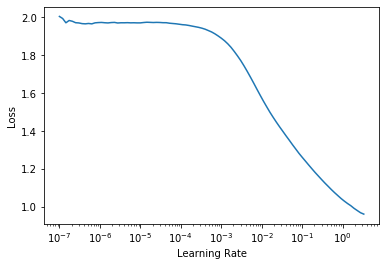

In [52]:
learn.lr_find()

In [53]:
learn.fit_one_cycle(140, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.639757,0.432058,0.813268,00:09
1,0.497604,0.397060,0.815878,00:10
2,0.444250,0.382453,0.819410,00:14
3,0.416564,0.373400,0.823710,00:15
4,0.398965,0.365969,0.826474,00:11
5,0.387112,0.361235,0.832156,00:10
6,0.380567,0.359283,0.834459,00:14
7,0.374530,0.356007,0.837684,00:13
8,0.372128,0.365416,0.833231,00:16
9,0.376165,0.372598,0.822482,00:18



KeyboardInterrupt



# Export

In [64]:
from nbdev.export import notebook2script
notebook2script()

Converted 01_core.ipynb.
Converted 02_model.ipynb.
Converted 03_experiments.ipynb.
Converted 04_self_supervision.ipynb.
Converted Untitled.ipynb.
Converted index.ipynb.
